第一部分 数据预处理

In [1]:
# 数据预处理函数定义
import csv
import os
import math
import numpy as np

def process_new2(input_file, output_file):
    csvfile=open(output_file, 'w',newline='')
    writer=csv.writer(csvfile)
    #writer.writerow(["id","id_num","id_dis","last_id","last_interval","interval",
                     #"data0","data1","data2","data3","data4","data5","data6","data7","data_c","data_last","isFirst","class"])
    id_num={} # id:次数
    id_t={}   # id:[时间戳,]
    id_data={} # id:[数据字段] 不管重不重复，按顺序记录
    # id_data2={} # id:[数据字段], 不管重不重复，按顺序记录
    # 上一条id
    idd = "0x000"
    # 上一条时间
    last_time = 0
    # 同id的上一条报文信息字典
    #last_same_id = {}
    # 记录上一个信息熵
    #data_c = 0
    # 数据字段，需要转成十进制
    data = []
    for i in range(0,8):
        data.append(0)
    # 上一条报文的数据字段、上一条同id报文的数据字段
    last_data = '0x0000000000000000'
    last_id_data = '0x0000000000000000'

    with open(input_file, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            # isFirst, 数据字段之前是否出现过, 1代表是第一次出现
            isFirst = 1
            # 处理数字字段的转换
            num = int(row[2])
            # 拼接数据字段得到的字符串
            dataString = ''
            for j in range(0,num):
                data[7-j] = eval("0x"+row[2+num-j])
                dataString = dataString + row[2+num-j]   
            # 第一次出现该id    
            if "0x"+row[1] not in id_num:
                time = [float(row[0])]
                dlc = [dataString]
                id_t["0x"+row[1]] = time
                id_data["0x"+row[1]] = dlc
                id_num["0x"+row[1]] = len(time) # 字典元素个数
                # last_same_id["0x"+row[1]] = 0
                interval = 0
                last_id_data = '0x0000000000000000'
            # 之前出现过该id
            else:
                time = id_t["0x"+row[1]]
                dlc = id_data["0x"+row[1]]
                last_id_data = '0x' + dlc[-1] 
                interval = float(row[0]) - time[-1]
                for i in time:
                    if float(row[0]) - i > 1:   # 去除时间间隔超过1s的
                        time.remove(i)
                    else:
                        break
                time.append(float(row[0]))
                if dataString not in dlc: # 数据字段之前没有出现过
                    isFirst = 1
                else:
                    isFirst = 0
                dlc.append(dataString)
                id_data.update({"0x"+row[1]:dlc})
                id_t.update({"0x"+row[1]:time})
                id_num.update({"0x"+row[1]:len(time)})
                # last_same_id.update({"0x"+row[1]:calc_ent(np.array(row[3:-1]))})
            last_interval = float(row[0]) - last_time
            id_dis = eval("0x"+row[1])^eval(idd) # 与前一个id的异或
            # d = calc_ent(np.array(row[3:-1])) # 某条报文数据字段形成的矩阵，如['d8', '00', '00', '8b', '00', '00', '00', '00']

            # 打标签
            if row[-1] == "R":
                writer.writerow([eval("0x"+row[1]),id_num["0x"+row[1]],id_dis,eval(idd),last_interval,interval,
                                 data[0],data[1],data[2],data[3],data[4],data[5],data[6],data[7],
                                 bin(int('0x'+dataString,16)^int(last_data,16)).count('1'),
                                 bin(int('0x'+dataString,16)^int(last_id_data,16)).count('1'),isFirst,'R'])
            else:
                writer.writerow([eval("0x"+row[1]),id_num["0x"+row[1]],id_dis,eval(idd),last_interval,interval,
                                 data[0],data[1],data[2],data[3],data[4],data[5],data[6],data[7],
                                 bin(int('0x'+dataString,16)^int(last_data,16)).count('1'),
                                 bin(int('0x'+dataString,16)^int(last_id_data,16)).count('1'),isFirst,'T'])
            # data_c = d
            idd = "0x"+row[1]
            for j in range(0,8):
                data[j]=0
            last_time = float(row[0])
            #last_same_id.update({"0x"+row[1]:calc_ent(np.array(row[3:-1]))})
            last_data = '0x' + dataString 
    f.close()
    csvfile.close()
    print("done")

In [ ]:
# 对3种攻击文件进行预处理
process_new2('DoS Attack_dataset.csv','DoS3.csv')
process_new2('Fuzzy Attack_dataset.csv','Fuzzy3.csv')
process_new2('Spoofing the drive gear_dataset.csv','SpoofingGEAR3.csv')

In [6]:
# 构造训练集和测试集，训练时从训练集中划分验证集
# 训练集：4个数据集各取30万条，标签：正常0，Fuzzy1，Dos2，Spoofing3
# 测试集：4个数据集各取10万条
import csv
import os
import math
import numpy as np

train_output_file = open('./multiply_train_final.csv', 'w',newline='')
test_output_file = open('./multiply_test_final.csv', 'w',newline='')
train_writer_file = csv.writer(train_output_file)
test_writer_file = csv.writer(test_output_file)
train_writer_file.writerow(["id","id_num","id_dis","last_id","last_interval","interval",
                     "data0","data1","data2","data3","data4","data5","data6","data7","data_c","data_last","isFirst","class"])
test_writer_file.writerow(["id","id_num","id_dis","last_id","last_interval","interval",
                     "data0","data1","data2","data3","data4","data5","data6","data7","data_c","data_last","isFirst","class"])

currentNum=0
trainNum=300000
testNum=100000

print("1.Fuzzy")
with open('Fuzzy3.csv', 'r') as f:
    reader=csv.reader(f)
    for row in reader:
        # 跳过第一行
        if row[0] == 'id':
            continue
        if currentNum < trainNum:
            if row[-1] == 'R':
                train_writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],
                                  row[9],row[10],row[11],row[12],row[13],row[14],row[15],row[16],'T0'])
            else:
                train_writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],
                                  row[9],row[10],row[11],row[12],row[13],row[14],row[15],row[16],'T1']) # Fuzzy:1
        elif currentNum < trainNum + testNum:
            if row[-1] == 'R':
                test_writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],
                                  row[9],row[10],row[11],row[12],row[13],row[14],row[15],row[16],'T0'])
            else:
                test_writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],
                                  row[9],row[10],row[11],row[12],row[13],row[14],row[15],row[16],'T1']) # Fuzzy:1
        else:
            break
        currentNum=currentNum+1
currentNum=0
f.close()

print("2.DoS")
with open('DoS3.csv', 'r') as f:
    reader=csv.reader(f)
    for row in reader:
        # 跳过第一行
        if row[0] == 'id':
            continue
        if currentNum < trainNum:
            if row[-1] == 'R':
                train_writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],
                                  row[9],row[10],row[11],row[12],row[13],row[14],row[15],row[16],'T0'])
            else:
                train_writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],
                                  row[9],row[10],row[11],row[12],row[13],row[14],row[15],row[16],'T2']) # DoS:2
        elif currentNum < trainNum + testNum:
            if row[-1] == 'R':
                test_writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],
                                  row[9],row[10],row[11],row[12],row[13],row[14],row[15],row[16],'T0'])
            else:
                test_writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],
                                  row[9],row[10],row[11],row[12],row[13],row[14],row[15],row[16],'T2']) # DoS:2
        else:
            break
        currentNum=currentNum+1
currentNum=0
f.close()

print("3.SpoofingGEAR")
with open('SpoofingGEAR3.csv', 'r') as f:
    reader=csv.reader(f)
    for row in reader:
        # 跳过第一行
        if row[0] == 'id':
            continue
        if currentNum < trainNum:
            if row[-1] == 'R':
                train_writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],
                                  row[9],row[10],row[11],row[12],row[13],row[14],row[15],row[16],'T0'])
            else:
                train_writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],
                                  row[9],row[10],row[11],row[12],row[13],row[14],row[15],row[16],'T3']) # Spoofing: 3
        elif currentNum < trainNum + testNum:
            if row[-1] == 'R':
                test_writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],
                                  row[9],row[10],row[11],row[12],row[13],row[14],row[15],row[16],'T0'])
            else:
                test_writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],
                                  row[9],row[10],row[11],row[12],row[13],row[14],row[15],row[16],'T3']) # Spoofing: 3
        else:
            break
        currentNum=currentNum+1
currentNum=0
f.close()

train_output_file.close()
test_output_file.close()
print("done")

1.Fuzzy
2.DoS
3.SpoofingGEAR
done


第二部分 输入训练集，训练模型，找出最优迭代轮数，确定和保存模型

In [7]:
# 训练并确定模型，并保存
# 训练过程结果可不输出
import os
import numpy as np
import keras as K
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
from keras.layers import LSTM, Dense, Activation,Input,core,Dropout
from keras.models import Model
from keras.callbacks import Callback
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

# 读取CSV数据集，并拆分为训练集和测试集
# 该函数的传入参数为CSV_FILE_PATH: csv文件路径

def TP(y_true,y_pred):
    TP=tf.reduce_sum(y_true*tf.round(y_pred))
    return TP

def TN(y_true,y_pred):
    TN=tf.reduce_sum((1-y_true)*(1-tf.round(y_pred)))
    return TN

def FP(y_true,y_pred):
    FP=tf.reduce_sum((1-y_true)*tf.round(y_pred))
    return FP

def FN(y_true,y_pred):
    FN=tf.reduce_sum(y_true*(1-tf.round(y_pred)))
    return FN

class LossHistory(K.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

def load_data(CSV_FILE_PATH, size1, size2):
    CAN = pd.read_csv(CSV_FILE_PATH)
    target_var = 'class'  # 目标变量
    # 数据集的特征
    features = list(CAN.columns)
    features.remove(target_var)
    features.remove('id_dis')
    # 目标变量的类别
    Class = CAN[target_var].unique()
    # 目标变量的类别字典
    Class_dict = dict(zip(Class, range(len(Class))))
    # 增加一列target, 将目标变量进行编码
    CAN['target'] = CAN[target_var].apply(lambda x: Class_dict[x])
    # 对目标变量进行0-1编码(One-hot Encoding)
    lb = LabelBinarizer()
    lb.fit(list(Class_dict.values()))
    transformed_labels = lb.transform(CAN['target'])
    y_bin_labels = []  # 对多分类进行0-1编码的变量
    for i in range(transformed_labels.shape[1]):
        y_bin_labels.append('y' + str(i))
        CAN['y' + str(i)] = transformed_labels[:, i]
    # 将数据集分为训练集和验证集
    train_x, val_x, train_y, val_y = train_test_split(CAN[features], CAN[y_bin_labels], \
                                                        train_size=size1, test_size=size2, random_state=0) # shuffle=True, stratify=None
    print(type(Class_dict))
    print(Class_dict)
    return train_x, val_x, train_y, val_y, Class_dict


# 0. 开始
print("\nCAN dataset using Keras/TensorFlow ")
np.random.seed(4)
tf.random.set_seed(13)

# 1. 读取CSV数据集
print("Loading CAN data into memory")
CSV_FILE_PATH = './multiply_train_final.csv'
train_x, val_x, train_y, val_y, Class_dict = load_data(CSV_FILE_PATH, 0.9, 0.1)
train_x = train_x.values.reshape(train_x.shape[0],1,16)
val_x = val_x.values.reshape(val_x.shape[0],1,16)


# 2. 定义模型
init = K.initializers.glorot_uniform(seed=1)
simple_adam = K.optimizers.Adam()
model = K.models.Sequential()
model.add(LSTM(units=256,input_shape=(1, 16),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=128,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=32, kernel_initializer=init, activation='linear'))
model.add(Dense(4,activation='softmax'))
#model.add(Activation('tanh'))
#model.add(K.layers.Dense(units=6, kernel_initializer=init, activation='relu'))
#model.add(K.layers.Dense(units=2, kernel_initializer=init, activation='sigmoid'))
#model.compile(loss='categorical_crossentropy', optimizer=simple_adam, metrics=['accuracy'])'''
#rmsprop = RMSprop(lr=0.01)
#model.compile(loss='mae', optimizer='rmsprop', metrics=['accuracy',TP,TN,FP,FN])
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
#print(model.summary())
# 3. 训练模型
b_size = 64
max_epochs = 20
# max_epochs = 2
history = LossHistory()
print("Starting training ")
h = model.fit(train_x, train_y, batch_size=b_size, epochs=max_epochs, shuffle=True, verbose=1,callbacks=[history], validation_data=(val_x, val_y))
# model.save("./lstm_multi_final.h5")


CAN dataset using Keras/TensorFlow 
Loading CAN data into memory
<class 'dict'>
{'T0': 0, 'T1': 1, 'T2': 2, 'T3': 3}
Starting training 
Epoch 1/20
12657/12657 [==============================] - 99s 8ms/step - loss: 0.0124 - accuracy: 0.9970 - val_loss: 0.0038 - val_accuracy: 0.9994
Epoch 2/20
12657/12657 [==============================] - 98s 8ms/step - loss: 0.0063 - accuracy: 0.9989 - val_loss: 0.0055 - val_accuracy: 0.9993
Epoch 3/20
12657/12657 [==============================] - 98s 8ms/step - loss: 0.0066 - accuracy: 0.9990 - val_loss: 0.0046 - val_accuracy: 0.9993
Epoch 4/20
12657/12657 [==============================] - 98s 8ms/step - loss: 0.0064 - accuracy: 0.9990 - val_loss: 0.0059 - val_accuracy: 0.9991
Epoch 5/20
12657/12657 [==============================] - 96s 8ms/step - loss: 0.0064 - accuracy: 0.9990 - val_loss: 0.0051 - val_accuracy: 0.9991
Epoch 6/20
12657/12657 [==============================] - 94s 7ms/step - loss: 0.0066 - accuracy: 0.9991 - val_loss: 0.0055 - va

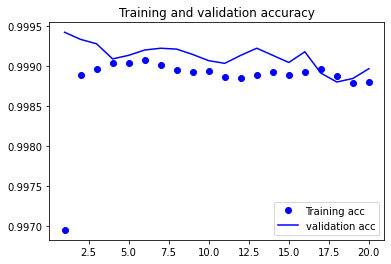

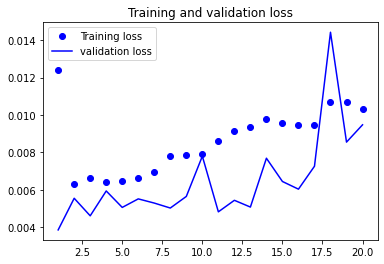

[0.0038462134543806314, 0.005539278034120798, 0.004600683692842722, 0.005930083338171244, 0.00505024055019021, 0.005506544373929501, 0.005282422993332148, 0.005017001181840897, 0.005638128146529198, 0.0077916583977639675, 0.004813791252672672, 0.005430659279227257, 0.005068838130682707, 0.007681648246943951, 0.006437224801629782, 0.006026832386851311, 0.0072532715275883675, 0.014422506093978882, 0.008544129319489002, 0.00946967862546444]
20
0.0038462134543806314 0
12657/12657 [==============================] - 94s 7ms/step - loss: 0.0105 - accuracy: 0.9987 - val_loss: 0.0078 - val_accuracy: 0.9991


In [14]:
# 展示训练结果
import matplotlib.pyplot as plt
acc = h.history['accuracy']
loss = h.history['loss']
val_acc = h.history['val_accuracy']
val_loss = h.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 根据验证集最小损失确定迭代轮数，确定并保存模型
print(val_loss)
print(len(val_loss))
min_num = val_loss[0]
min_index = 0
for i in range(len(val_loss)):
    if val_loss[i] < min_num:
        min_num = val_acc[i]
        min_index = i

print(min_num,min_index)

h = model.fit(train_x, train_y, batch_size=b_size, epochs=min_index+1, shuffle=True, verbose=1,callbacks=[history], validation_data=(val_x, val_y))
model.save("./lstm_multi_final.h5")

第三部分 输入测试集，展示效果

In [17]:
# 测试，展示测试结果
# 为了和网站匹配及展示的方便，使用刚刚保存的模型
from keras.models import load_model
# 0. 开始
print("\nCAN dataset using Keras/TensorFlow ")
np.random.seed(4)
tf.random.set_seed(13)

# 1. 读取CSV数据集
print("Loading CAN data into memory")
CSV_FILE_PATH = './multiply_test_final.csv'
train_x, test_x, train_y, test_y, Class_dict = load_data(CSV_FILE_PATH, 0.01, 0.99)
#train_x = train_x.values.reshape(train_x.shape[0],1,16)
test_x = test_x.values.reshape(test_x.shape[0],1,16)

# 加载刚刚保存的模型
final_model = load_model('./lstm_multi_final.h5')
# 测试模型的结果
eval2 = model.evaluate(test_x, test_y, verbose=0)
print('测试集上的loss和acc：')
print(eval2)


CAN dataset using Keras/TensorFlow 
Loading CAN data into memory
<class 'dict'>
{'T0': 0, 'T1': 1, 'T2': 2, 'T3': 3}
测试集上的loss和acc：
[0.004908901639282703, 0.9994276165962219]


In [18]:
# 详细评估指标
predictions = final_model.predict(test_x)
from sklearn.metrics import classification_report
print(classification_report(test_y.values.argmax(axis=-1), predictions.argmax(axis=-1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    247114
           1       1.00      0.99      0.99     15926
           2       1.00      1.00      1.00     18044
           3       1.00      1.00      1.00     15916

    accuracy                           1.00    297000
   macro avg       1.00      1.00      1.00    297000
weighted avg       1.00      1.00      1.00    297000



In [19]:
# 混淆矩阵
from sklearn.metrics import confusion_matrix
confusion_matrix(test_y.values.argmax(axis=-1), predictions.argmax(axis=-1))

array([[247085,     26,      0,      3],
       [   137,  15789,      0,      0],
       [     0,      0,  18044,      0],
       [     4,      0,      0,  15912]], dtype=int64)

In [22]:
predictions

array([[9.9999321e-01, 6.7649075e-06, 8.8312692e-32, 2.9107981e-18],
       [5.9153297e-04, 9.9940848e-01, 2.9052836e-09, 3.6726991e-13],
       [9.9999321e-01, 6.7586652e-06, 8.8143069e-32, 2.9008664e-18],
       ...,
       [9.9999321e-01, 6.7729638e-06, 8.8262851e-32, 2.9050523e-18],
       [9.9999321e-01, 6.7562937e-06, 8.8114827e-32, 2.9038777e-18],
       [9.9999321e-01, 6.7552628e-06, 8.8175348e-32, 2.9076019e-18]],
      dtype=float32)

In [23]:
test_y

,y0,y1,y2,y3
112692,1,0,0,0
19498,0,1,0,0
31689,1,0,0,0
231780,0,0,0,1
4298,0,1,0,0
...,...,...,...,...
153151,0,0,1,0
290219,1,0,0,0
79696,1,0,0,0
225648,1,0,0,0


In [31]:
predictions.argmax(axis=-1)[0:100]

array([0, 1, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 2, 0, 0, 3, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], dtype=int64)

In [30]:
test_y.values.argmax(axis=-1)[0:100]

array([0, 1, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 2, 0, 0, 3, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], dtype=int64)

In [32]:
confusion_matrix(test_y.values.argmax(axis=-1)[0:100], predictions.argmax(axis=-1)[0:100])

array([[85,  0,  0,  0],
       [ 0,  5,  0,  0],
       [ 0,  0,  4,  0],
       [ 0,  0,  0,  6]], dtype=int64)

In [ ]:
二分类验证，与对比论文比较

In [6]:
# 构造训练集和测试集，训练时从训练集中划分验证集
# 训练集：二分类，30万条
# 测试集：二分类，10万条
import csv
import os
import math
import numpy as np

def class_2(infile,file1, file2,num):
    train_output_file = open(file1, 'w',newline='')
    test_output_file = open(file2, 'w',newline='')
    train_writer_file = csv.writer(train_output_file)
    test_writer_file = csv.writer(test_output_file)
    train_writer_file.writerow(["id","id_num","id_dis","last_id","last_interval","interval",
                         "data0","data1","data2","data3","data4","data5","data6","data7","data_c","data_last","isFirst","class"])
    test_writer_file.writerow(["id","id_num","id_dis","last_id","last_interval","interval",
                         "data0","data1","data2","data3","data4","data5","data6","data7","data_c","data_last","isFirst","class"])

    currentNum=0
    trainNum=0.7*num
    testNum=0.3*num

    print(infile)
    with open(infile, 'r') as f:
        reader=csv.reader(f)
        for row in reader:
            # 跳过第一行
            if row[0] == 'id':
                continue
            if currentNum < trainNum:
                if row[-1] == 'R':
                    train_writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],
                                      row[9],row[10],row[11],row[12],row[13],row[14],row[15],row[16],'T0'])
                else:
                    train_writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],
                                      row[9],row[10],row[11],row[12],row[13],row[14],row[15],row[16],'T1']) # Fuzzy:1
            elif currentNum < trainNum + testNum:
                if row[-1] == 'R':
                    test_writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],
                                      row[9],row[10],row[11],row[12],row[13],row[14],row[15],row[16],'T0'])
                else:
                    test_writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],
                                      row[9],row[10],row[11],row[12],row[13],row[14],row[15],row[16],'T1']) # Fuzzy:1
            else:
                break
            currentNum=currentNum+1
    currentNum=0
    f.close()

In [8]:
class_2('Fuzzy3.csv','Fuzzy_train_final.csv','Fuzzy_test_final.csv',500000)
class_2('DoS3.csv','DoS_train_final.csv','DoS_test_final.csv',500000)
class_2('SpoofingGEAR3.csv','SpoofingGEAR3_train_final.csv','SpoofingGEAR3_test_final.csv',500000)

Fuzzy3.csv
DoS3.csv
SpoofingGEAR3.csv


1、Fuzzy

In [1]:
# 训练并确定模型，并保存
# 训练过程结果可不输出
import os
import numpy as np
import keras as K
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
from keras.layers import LSTM, Dense, Activation,Input,core,Dropout
from keras.models import Model
from keras.callbacks import Callback
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

# 读取CSV数据集，并拆分为训练集和测试集
# 该函数的传入参数为CSV_FILE_PATH: csv文件路径

def TP(y_true,y_pred):
    TP=tf.reduce_sum(y_true*tf.round(y_pred))
    return TP

def TN(y_true,y_pred):
    TN=tf.reduce_sum((1-y_true)*(1-tf.round(y_pred)))
    return TN

def FP(y_true,y_pred):
    FP=tf.reduce_sum((1-y_true)*tf.round(y_pred))
    return FP

def FN(y_true,y_pred):
    FN=tf.reduce_sum(y_true*(1-tf.round(y_pred)))
    return FN

class LossHistory(K.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

def load_data(CSV_FILE_PATH, size1, size2):
    CAN = pd.read_csv(CSV_FILE_PATH)
    target_var = 'class'  # 目标变量
    # 数据集的特征
    features = list(CAN.columns)
    features.remove(target_var)
    features.remove('id_dis')
    # 目标变量的类别
    Class = CAN[target_var].unique()
    # 目标变量的类别字典
    Class_dict = dict(zip(Class, range(len(Class))))
    # 增加一列target, 将目标变量进行编码
    CAN['target'] = CAN[target_var].apply(lambda x: Class_dict[x])
    # 对目标变量进行0-1编码(One-hot Encoding)
    lb = LabelBinarizer()
    lb.fit(list(Class_dict.values()))
    transformed_labels = lb.transform(CAN['target'])
    y_bin_labels = []  # 对多分类进行0-1编码的变量
    for i in range(transformed_labels.shape[1]):
        y_bin_labels.append('y' + str(i))
        CAN['y' + str(i)] = transformed_labels[:, i]
    # 将数据集分为训练集和验证集
    train_x, val_x, train_y, val_y = train_test_split(CAN[features], CAN[y_bin_labels], \
                                                        train_size=size1, test_size=size2, shuffle=False, random_state=0) # shuffle=True, stratify=None
    print(type(Class_dict))
    print(Class_dict)
    return train_x, val_x, train_y, val_y, Class_dict

def train_and_test(file1,file2,model1):
    # 0. 开始
    print("\nCAN dataset using Keras/TensorFlow ")
    np.random.seed(4)
    tf.random.set_seed(13)

    # 1. 读取CSV数据集
    print("Loading CAN data into memory")
    CSV_FILE_PATH = file1
    train_x, val_x, train_y, val_y, Class_dict = load_data(CSV_FILE_PATH, 0.9, 0.1)
    #train_x = train_x.values.reshape(train_x.shape[0],1,16)
    #val_x = val_x.values.reshape(val_x.shape[0],1,16)
    train_y=train_y.drop(index=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,
                                31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48])
    print(train_y.shape)
    val_y=val_y.drop(index=[train_x.shape[0]+0,train_x.shape[0]+1,train_x.shape[0]+2,train_x.shape[0]+3,train_x.shape[0]+4,
                       train_x.shape[0]+5,train_x.shape[0]+6,train_x.shape[0]+7,train_x.shape[0]+8,train_x.shape[0]+9,train_x.shape[0]+10,
                           train_x.shape[0]+11,train_x.shape[0]+12,train_x.shape[0]+13,train_x.shape[0]+14,train_x.shape[0]+15,
                           train_x.shape[0]+16,train_x.shape[0]+17,train_x.shape[0]+18,train_x.shape[0]+19,train_x.shape[0]+20,
                           train_x.shape[0]+21,train_x.shape[0]+22,train_x.shape[0]+23,train_x.shape[0]+24,train_x.shape[0]+25,
                           train_x.shape[0]+26,train_x.shape[0]+27,train_x.shape[0]+28,train_x.shape[0]+29,train_x.shape[0]+30,
                           train_x.shape[0]+31,train_x.shape[0]+32,train_x.shape[0]+33,train_x.shape[0]+34,train_x.shape[0]+35,
                           train_x.shape[0]+36,train_x.shape[0]+37,train_x.shape[0]+38,train_x.shape[0]+39,train_x.shape[0]+40,
                           train_x.shape[0]+41,train_x.shape[0]+42,train_x.shape[0]+43,train_x.shape[0]+44,train_x.shape[0]+45,
                           train_x.shape[0]+46,train_x.shape[0]+47,train_x.shape[0]+48])
    print(val_y.shape)
    train_x = series_to_supervised(train_x, 49)
    val_x = series_to_supervised(val_x, 49)
    train_x = train_x.values.reshape(train_x.shape[0],50,16)
    print(train_x.shape)
    val_x = val_x.values.reshape(val_x.shape[0],50,16)
    print(val_x.shape)


    # 2. 定义模型
    init = K.initializers.glorot_uniform(seed=1)
    simple_adam = K.optimizers.Adam()
    model = K.models.Sequential()
    model.add(LSTM(units=256,input_shape=(50, 16),return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=128,return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=32, kernel_initializer=init, activation='linear'))
    model.add(Dense(1,activation='tanh'))
    #model.add(Activation('tanh'))
    #model.add(K.layers.Dense(units=6, kernel_initializer=init, activation='relu'))
    #model.add(K.layers.Dense(units=2, kernel_initializer=init, activation='sigmoid'))
    #model.compile(loss='categorical_crossentropy', optimizer=simple_adam, metrics=['accuracy'])'''
    #rmsprop = RMSprop(lr=0.01)
    #model.compile(loss='mae', optimizer='rmsprop', metrics=['accuracy',TP,TN,FP,FN])
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    #print(model.summary())
    # 3. 训练模型
    b_size = 256
    max_epochs = 5
    # max_epochs = 2
    history = LossHistory()
    print("Starting training ")
    h = model.fit(train_x, train_y, batch_size=b_size, epochs=max_epochs, shuffle=True, verbose=1,callbacks=[history], validation_data=(val_x, val_y))

    # 展示训练结果
    import matplotlib.pyplot as plt
    acc = h.history['accuracy']
    loss = h.history['loss']
    val_acc = h.history['val_accuracy']
    val_loss = h.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label = 'Training acc')
    plt.plot(epochs, val_acc, 'b', label = 'validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label = 'Training loss')
    plt.plot(epochs, val_loss, 'b', label = 'validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

    # 根据验证集最小损失确定迭代轮数，确定并保存模型
    print(val_loss)
    print(len(val_loss))
    min_num = val_loss[0]
    min_index = 0
    for i in range(len(val_loss)):
        if val_loss[i] < min_num:
            min_num = val_acc[i]
            min_index = i

    print(min_num,min_index)

    h = model.fit(train_x, train_y, batch_size=b_size, epochs=min_index+1, shuffle=True, verbose=1,callbacks=[history], validation_data=(val_x, val_y))
    model.save(model1)

    # 测试，展示测试结果
    # 为了和网站匹配及展示的方便，使用刚刚保存的模型
    from keras.models import load_model
    # 0. 开始
    print("\nCAN dataset using Keras/TensorFlow ")
    np.random.seed(4)
    tf.random.set_seed(13)

    # 1. 读取CSV数据集
    print("Loading CAN data into memory")
    CSV_FILE_PATH = file2
    train_x, test_x, train_y, test_y, Class_dict = load_data(CSV_FILE_PATH, 0.01, 0.99)
    #train_x = train_x.values.reshape(train_x.shape[0],1,16)
    #test_x = test_x.values.reshape(test_x.shape[0],1,16)
    train_y=train_y.drop(index=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,
                                31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48])
    print(train_y.shape)
    test_y=test_y.drop(index=[train_x.shape[0]+0,train_x.shape[0]+1,train_x.shape[0]+2,train_x.shape[0]+3,train_x.shape[0]+4,
                       train_x.shape[0]+5,train_x.shape[0]+6,train_x.shape[0]+7,train_x.shape[0]+8,train_x.shape[0]+9,train_x.shape[0]+10,
                           train_x.shape[0]+11,train_x.shape[0]+12,train_x.shape[0]+13,train_x.shape[0]+14,train_x.shape[0]+15,
                           train_x.shape[0]+16,train_x.shape[0]+17,train_x.shape[0]+18,train_x.shape[0]+19,train_x.shape[0]+20,
                           train_x.shape[0]+21,train_x.shape[0]+22,train_x.shape[0]+23,train_x.shape[0]+24,train_x.shape[0]+25,
                           train_x.shape[0]+26,train_x.shape[0]+27,train_x.shape[0]+28,train_x.shape[0]+29,train_x.shape[0]+30,
                           train_x.shape[0]+31,train_x.shape[0]+32,train_x.shape[0]+33,train_x.shape[0]+34,train_x.shape[0]+35,
                           train_x.shape[0]+36,train_x.shape[0]+37,train_x.shape[0]+38,train_x.shape[0]+39,train_x.shape[0]+40,
                           train_x.shape[0]+41,train_x.shape[0]+42,train_x.shape[0]+43,train_x.shape[0]+44,train_x.shape[0]+45,
                           train_x.shape[0]+46,train_x.shape[0]+47,train_x.shape[0]+48])
    print(test_y.shape)
    train_x = series_to_supervised(train_x, 49)
    test_x = series_to_supervised(test_x, 49)
    train_x = train_x.values.reshape(train_x.shape[0],50,16)
    print(train_x.shape)
    test_x = test_x.values.reshape(test_x.shape[0],50,16)
    print(test_x.shape)


    # 加载刚刚保存的模型
    final_model = load_model(model1)
    # 测试模型的结果
    eval2 = final_model.evaluate(test_x, test_y, verbose=0)
    print('测试集上的loss和acc：')
    print(eval2)

    # 详细评估指标
    predictions = final_model.predict(test_x)
    from sklearn.metrics import classification_report
    print(classification_report(test_y.values, np.int64(predictions > 0.5),digits=4))

    # 混淆矩阵
    from sklearn.metrics import confusion_matrix
    print(confusion_matrix(test_y, np.int64(predictions > 0.5)))

In [2]:
train_and_test('Fuzzy_train_final.csv','Fuzzy_test_final.csv','Fuzzy_final.h5')


CAN dataset using Keras/TensorFlow 
Loading CAN data into memory
<class 'dict'>
{'T0': 0, 'T1': 1}
(314951, 1)
(34951, 1)


NameError: name 'series_to_supervised' is not defined


CAN dataset using Keras/TensorFlow 
Loading CAN data into memory
<class 'dict'>
{'T0': 0, 'T1': 1}
Starting training 
Epoch 1/5
36085/36085 [==============================] - 429s 12ms/step - loss: 0.0023 - accuracy: 0.9997 - val_loss: 5.0881e-09 - val_accuracy: 1.0000
Epoch 2/5
36085/36085 [==============================] - 406s 11ms/step - loss: 8.8644e-04 - accuracy: 0.9999 - val_loss: 5.9427e-05 - val_accuracy: 1.0000
Epoch 3/5
36085/36085 [==============================] - 413s 11ms/step - loss: 6.6406e-04 - accuracy: 0.9999 - val_loss: 3.4246e-06 - val_accuracy: 1.0000
Epoch 4/5
36085/36085 [==============================] - 409s 11ms/step - loss: 1.9650e-04 - accuracy: 1.0000 - val_loss: 1.2136e-04 - val_accuracy: 1.0000
Epoch 5/5
36085/36085 [==============================] - 406s 11ms/step - loss: 3.6265e-04 - accuracy: 1.0000 - val_loss: 1.3624e-05 - val_accuracy: 1.0000


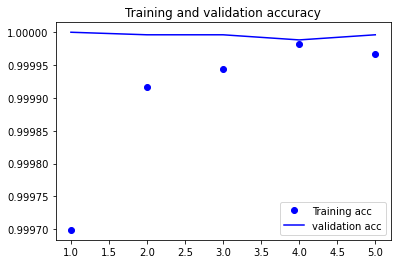

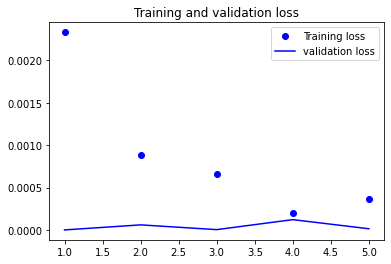

[5.088052201784876e-09, 5.9426893130876124e-05, 3.4245665574417217e-06, 0.00012135593715356663, 1.3624086932395585e-05]
5
5.088052201784876e-09 0
36085/36085 [==============================] - 398s 11ms/step - loss: 5.5369e-04 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000

CAN dataset using Keras/TensorFlow 
Loading CAN data into memory
<class 'dict'>
{'T0': 0, 'T1': 1}
测试集上的loss和acc：
[1.1056346011173446e-05, 0.9999963045120239]
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000   1067773
           1     0.9998    1.0000    0.9999     20960

    accuracy                         1.0000   1088733
   macro avg     0.9999    1.0000    1.0000   1088733
weighted avg     1.0000    1.0000    1.0000   1088733

[[1067769       4]
 [      0   20960]]


In [72]:
train_and_test('DoS_train_final.csv','DoS_test_final.csv','DoS_final.h5')


CAN dataset using Keras/TensorFlow 
Loading CAN data into memory
<class 'dict'>
{'T0': 0, 'T1': 1}
Starting training 
Epoch 1/5
35280/35280 [==============================] - 381s 11ms/step - loss: 0.0034 - accuracy: 0.9995 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/5
35280/35280 [==============================] - 408s 12ms/step - loss: 2.9531e-04 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/5
35280/35280 [==============================] - 413s 12ms/step - loss: 2.0178e-04 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/5
35280/35280 [==============================] - 410s 12ms/step - loss: 1.0926e-04 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/5
35280/35280 [==============================] - 408s 12ms/step - loss: 8.0499e-05 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


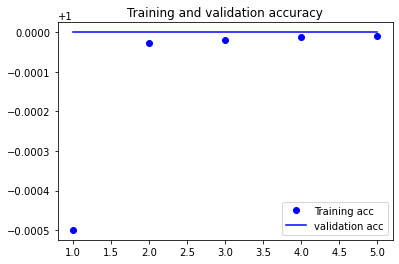

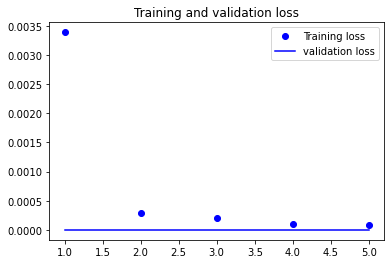

[0.0, 0.0, 0.0, 0.0, 0.0]
5
0.0 0
35280/35280 [==============================] - 408s 12ms/step - loss: 4.4945e-05 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000

CAN dataset using Keras/TensorFlow 
Loading CAN data into memory
<class 'dict'>
{'T0': 0, 'T1': 1}
测试集上的loss和acc：
[0.0011606679763644934, 0.9999192357063293]
              precision    recall  f1-score   support

           0     1.0000    0.9999    1.0000    895045
           1     0.9995    1.0000    0.9997    169391

    accuracy                         0.9999   1064436
   macro avg     0.9997    1.0000    0.9998   1064436
weighted avg     0.9999    0.9999    0.9999   1064436

[[894959     86]
 [     0 169391]]


In [73]:
train_and_test('SpoofingGEAR3_train_final.csv','SpoofingGEAR3_test_final.csv','SpoofingGEAR3_final.h5')

In [83]:
def load_data(CSV_FILE_PATH, size1, size2):
    CAN = pd.read_csv(CSV_FILE_PATH)
    target_var = 'class'  # 目标变量
    # 数据集的特征
    features = list(CAN.columns)
    features.remove(target_var)
    features.remove('id_dis')
    # 目标变量的类别
    Class = CAN[target_var].unique()
    # 目标变量的类别字典
    Class_dict = dict(zip(Class, range(len(Class))))
    # 增加一列target, 将目标变量进行编码
    CAN['target'] = CAN[target_var].apply(lambda x: Class_dict[x])
    # 对目标变量进行0-1编码(One-hot Encoding)
    lb = LabelBinarizer()
    lb.fit(list(Class_dict.values()))
    transformed_labels = lb.transform(CAN['target'])
    y_bin_labels = []  # 对多分类进行0-1编码的变量
    for i in range(transformed_labels.shape[1]):
        y_bin_labels.append('y' + str(i))
        CAN['y' + str(i)] = transformed_labels[:, i]
    # 将数据集分为训练集和验证集
    train_x, val_x, train_y, val_y = train_test_split(CAN[features], CAN[y_bin_labels], \
                                                        train_size=size1, test_size=size2, shuffle=False, random_state=0) # shuffle=True, stratify=None
    print(type(Class_dict))
    print(Class_dict)
    return train_x, val_x, train_y, val_y, Class_dict

In [106]:
train_x, val_x, train_y, val_y, Class_dict = load_data('osd.csv')

<class 'dict'>
{'R': 0, 'T': 1}


SyntaxError: invalid syntax (<ipython-input-112-dc7ad6440c30>, line 1)

In [77]:
train_x1 = train_x.values.reshape(train_x.shape[0],1,train_x.shape[1])

In [78]:
train_x1

array([[[ 3.99000000e+02,  1.01000000e+02, -4.51205059e-01]],

       [[ 0.00000000e+00,  8.24000000e+02, -2.40563906e+00]],

       [[ 8.48000000e+02,  1.01000000e+02,  1.20120506e+00]],

       ...,

       [[ 3.05000000e+02,  7.80000000e+01,  0.00000000e+00]],

       [[ 4.97000000e+02,  5.10000000e+01, -1.61207462e+00]],

       [[ 0.00000000e+00,  6.61000000e+02,  0.00000000e+00]]])

In [79]:
train_x2 = train_x.values.reshape(train_x.shape[0],2,train_x.shape[1])

ValueError: cannot reshape array of size 37596 into shape (12532,2,3)

In [3]:
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 

#data = series_to_supervised(train_x, 3)
#print(data)

In [87]:
train_y

,y0
0,0
1,0
2,0
3,0
4,0
...,...
12527,0
12528,0
12529,0
12530,0


In [88]:
data[0:10]

,var1(t-3),var2(t-3),var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1),var1(t),var2(t),var3(t)
3,790.0,1.0,2.405639,399.0,1.0,-0.856844,608.0,1.0,1.451205,672,1,-0.250000
4,399.0,1.0,-0.856844,608.0,1.0,1.451205,672.0,1.0,-0.250000,809,1,0.000000
5,608.0,1.0,1.451205,672.0,1.0,-0.250000,809.0,1.0,0.000000,1349,1,-1.688722
6,672.0,1.0,-0.250000,809.0,1.0,0.000000,1349.0,1.0,-1.688722,2,1,0.487517
7,809.0,1.0,0.000000,1349.0,1.0,-1.688722,2.0,1.0,0.487517,339,1,0.201205
8,1349.0,1.0,-1.688722,2.0,1.0,0.487517,339.0,1.0,0.201205,704,1,-1.206436
9,2.0,1.0,0.487517,339.0,1.0,0.201205,704.0,1.0,-1.206436,304,1,2.206436
10,339.0,1.0,0.201205,704.0,1.0,-1.206436,304.0,1.0,2.206436,305,1,-0.250000
11,704.0,1.0,-1.206436,304.0,1.0,2.206436,305.0,1.0,-0.250000,320,1,-0.500000
12,304.0,1.0,2.206436,305.0,1.0,-0.250000,320.0,1.0,-0.500000,848,1,0.750000


In [91]:
data1=data.values.reshape(data.shape[0],4,3)

In [92]:
data1

array([[[ 7.90000000e+02,  1.00000000e+00,  2.40563906e+00],
        [ 3.99000000e+02,  1.00000000e+00, -8.56844122e-01],
        [ 6.08000000e+02,  1.00000000e+00,  1.45120506e+00],
        [ 6.72000000e+02,  1.00000000e+00, -2.50000000e-01]],

       [[ 3.99000000e+02,  1.00000000e+00, -8.56844122e-01],
        [ 6.08000000e+02,  1.00000000e+00,  1.45120506e+00],
        [ 6.72000000e+02,  1.00000000e+00, -2.50000000e-01],
        [ 8.09000000e+02,  1.00000000e+00,  0.00000000e+00]],

       [[ 6.08000000e+02,  1.00000000e+00,  1.45120506e+00],
        [ 6.72000000e+02,  1.00000000e+00, -2.50000000e-01],
        [ 8.09000000e+02,  1.00000000e+00,  0.00000000e+00],
        [ 1.34900000e+03,  1.00000000e+00, -1.68872188e+00]],

       ...,

       [[ 6.72000000e+02,  1.01000000e+02,  0.00000000e+00],
        [ 7.90000000e+02,  1.01000000e+02,  0.00000000e+00],
        [ 3.04000000e+02,  1.01000000e+02,  0.00000000e+00],
        [ 3.05000000e+02,  1.01000000e+02,  0.00000000e+00]],

   

In [95]:
data1.shape

(12529, 4, 3)

In [99]:
train_y.drop(index=[0,1,2])

,y0
3,0
4,0
5,0
6,0
7,0
...,...
12527,0
12528,0
12529,0
12530,0


,y0
965439,0
882973,0
520680,0
533982,0
859768,0
...,...
830306,0
510608,0
202702,1
883827,0



CAN dataset using Keras/TensorFlow 
Loading CAN data into memory
<class 'dict'>
{'R': 0, 'T': 1}
(9738, 1)
(4169, 1)
(9738, 10, 3)
(4169, 10, 3)
Starting training 
Epoch 1/5
609/609 [==============================] - 35s 57ms/step - loss: 0.0324 - accuracy: 0.9874
Epoch 2/5
609/609 [==============================] - 31s 51ms/step - loss: 0.0016 - accuracy: 0.9992
Epoch 3/5
609/609 [==============================] - 32s 53ms/step - loss: 9.7585e-04 - accuracy: 0.9996
Epoch 4/5
609/609 [==============================] - 33s 54ms/step - loss: 0.0011 - accuracy: 0.9993
Epoch 5/5
609/609 [==============================] - 32s 52ms/step - loss: 9.7133e-04 - accuracy: 0.9995
Training finished 



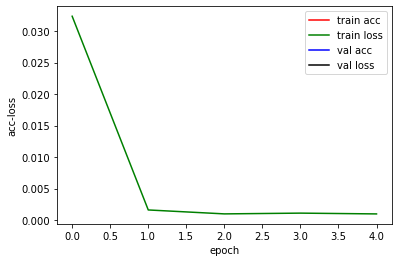

In [118]:
import os
import numpy as np
import keras as K
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
from keras.layers import LSTM, Dense, Activation,Input,core,Dropout
from keras.models import Model
from keras.callbacks import Callback
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

# 读取CSV数据集，并拆分为训练集和测试集
# 该函数的传入参数为CSV_FILE_PATH: csv文件路径

def TP(y_true,y_pred):
    TP=tf.reduce_sum(y_true*tf.round(y_pred))
    return TP

def TN(y_true,y_pred):
    TN=tf.reduce_sum((1-y_true)*(1-tf.round(y_pred)))
    return TN

def FP(y_true,y_pred):
    FP=tf.reduce_sum((1-y_true)*tf.round(y_pred))
    return FP

def FN(y_true,y_pred):
    FN=tf.reduce_sum(y_true*(1-tf.round(y_pred)))
    return FN

from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

class LossHistory(K.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

def load_data(CSV_FILE_PATH):
    CAN = pd.read_csv(CSV_FILE_PATH)
    target_var = 'class'  # 目标变量
    # 数据集的特征
    features = list(CAN.columns)
    features.remove(target_var)
    features.remove('id_dis')
    # 目标变量的类别
    Class = CAN[target_var].unique()
    # 目标变量的类别字典
    Class_dict = dict(zip(Class, range(len(Class))))
    # 增加一列target, 将目标变量进行编码
    CAN['target'] = CAN[target_var].apply(lambda x: Class_dict[x])
    # 对目标变量进行0-1编码(One-hot Encoding)
    lb = LabelBinarizer()
    lb.fit(list(Class_dict.values()))
    transformed_labels = lb.transform(CAN['target'])
    y_bin_labels = []  # 对多分类进行0-1编码的变量
    for i in range(transformed_labels.shape[1]):
        y_bin_labels.append('y' + str(i))
        CAN['y' + str(i)] = transformed_labels[:, i]
    # 将数据集分为训练集和测试集
    train_x, test_x, train_y, test_y = train_test_split(CAN[features], CAN[y_bin_labels], \
                                                        train_size=0.7, test_size=0.3, shuffle=False, random_state=0)
    print(type(Class_dict))
    print(Class_dict)
    return train_x, test_x, train_y, test_y, Class_dict

def main():

    # 0. 开始
    print("\nCAN dataset using Keras/TensorFlow ")
    np.random.seed(4)
    tf.random.set_seed(13)

    # 1. 读取CSV数据集
    print("Loading CAN data into memory")
    #CSV_FILE_PATH = 'spoofing.csv'
    CSV_FILE_PATH = 'osd.csv'
    train_x, test_x, train_y, test_y, Class_dict = load_data(CSV_FILE_PATH)
    #train_x = train_x.values.reshape(train_x.shape[0],1,3)
    #test_x = test_x.values.reshape(test_x.shape[0],1,3)
    train_y=train_y.drop(index=[0,1,2,3,4,5,6,7,8])
    print(train_y.shape)
    test_y=test_y.drop(index=[train_x.shape[0]+0,train_x.shape[0]+1,train_x.shape[0]+2,train_x.shape[0]+3,train_x.shape[0]+4,
                       train_x.shape[0]+5,train_x.shape[0]+6,train_x.shape[0]+7,train_x.shape[0]+8])
    print(test_y.shape)
    train_x = series_to_supervised(train_x, 9)
    test_x = series_to_supervised(test_x, 9)
    train_x = train_x.values.reshape(train_x.shape[0],10,3)
    print(train_x.shape)
    test_x = test_x.values.reshape(test_x.shape[0],10,3)
    print(test_x.shape)

    # 2. 定义模型
    init = K.initializers.glorot_uniform(seed=1)
    simple_adam = K.optimizers.Adam()
    model = K.models.Sequential()
    model.add(LSTM(units=256,input_shape=(10, 3),return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=128,return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=32, kernel_initializer=init, activation='linear'))
    model.add(Dense(1))
    model.add(Activation('tanh'))
    #model.add(K.layers.Dense(units=6, kernel_initializer=init, activation='relu'))
    #model.add(K.layers.Dense(units=2, kernel_initializer=init, activation='sigmoid'))
    #model.compile(loss='categorical_crossentropy', optimizer=simple_adam, metrics=['accuracy'])'''
    #rmsprop = RMSprop(lr=0.01)
    #model.compile(loss='mae', optimizer='rmsprop', metrics=['accuracy',TP,TN,FP,FN])
    model.compile(loss='mae', optimizer='rmsprop', metrics=['accuracy'])
    #print(model.summary())
    # 3. 训练模型
    b_size = 16
    max_epochs = 5
    # max_epochs = 2
    history = LossHistory()
    print("Starting training ")
    h = model.fit(train_x, train_y, batch_size=b_size, epochs=max_epochs, shuffle=True, verbose=1,callbacks=[history])
    #model.save("./lstm.h5")
    print("Training finished \n")

    # 4. 评估模型
    eval = model.evaluate(test_x, test_y, verbose=0)
    history.loss_plot('epoch')


main()

In [119]:
print(eval)

<built-in function eval>


In [104]:
test_x.shape

(1140141, 1, 16)


CAN dataset using Keras/TensorFlow 
Loading CAN data into memory
<class 'dict'>
{'T0': 0, 'T1': 1}
(2418473, 1)
(268712, 1)
(2418473, 10, 16)
(268712, 10, 16)
Starting training 
9448/9448 [==============================] - 1736s 184ms/step - loss: 0.0147 - accuracy: 0.9968 - val_loss: 0.0047 - val_accuracy: 0.9995


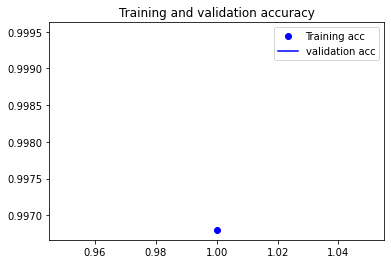

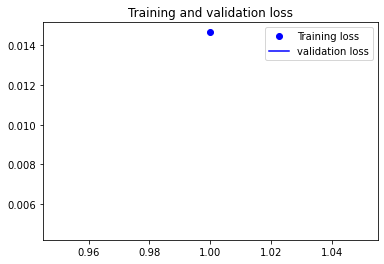

[0.004701440688222647]
1
0.004701440688222647 0
9448/9448 [==============================] - 1760s 186ms/step - loss: 0.0077 - accuracy: 0.9992 - val_loss: 0.0047 - val_accuracy: 0.9995

CAN dataset using Keras/TensorFlow 
Loading CAN data into memory
<class 'dict'>
{'T0': 0, 'T1': 1}
(11507, 1)
(268712, 1)
(11507, 10, 16)
(1140132, 10, 16)
测试集上的loss和acc：
[0.00173183623701334, 0.9998456239700317]
              precision    recall  f1-score   support

           0     0.9999    0.9999    0.9999   1097774
           1     0.9980    0.9978    0.9979     42358

    accuracy                         0.9998   1140132
   macro avg     0.9990    0.9989    0.9989   1140132
weighted avg     0.9998    0.9998    0.9998   1140132

[[1097690      84]
 [     92   42266]]


In [126]:
train_and_test('Fuzzy_train_final.csv','Fuzzy_test_final.csv','Fuzzy_final.h5')


CAN dataset using Keras/TensorFlow 
Loading CAN data into memory
<class 'dict'>
{'T0': 0, 'T1': 1}
(2309427, 1)
(256596, 1)
(2309427, 10, 16)
(256596, 10, 16)
Starting training 
9022/9022 [==============================] - 1642s 182ms/step - loss: 0.0028 - accuracy: 0.9991 - val_loss: 4.6724e-05 - val_accuracy: 1.0000


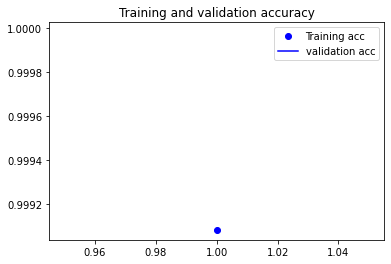

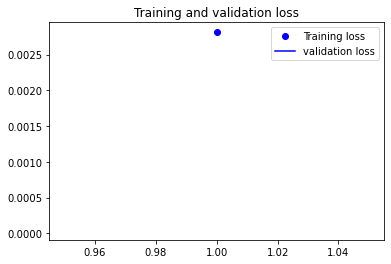

[4.672366412705742e-05]
1
4.672366412705742e-05 0
9022/9022 [==============================] - 1677s 186ms/step - loss: 3.5222e-04 - accuracy: 1.0000 - val_loss: 2.4046e-04 - val_accuracy: 1.0000

CAN dataset using Keras/TensorFlow 
Loading CAN data into memory
<class 'dict'>
{'T0': 0, 'T1': 1}
(10988, 1)
(256596, 1)
(10988, 10, 16)
(1088724, 10, 16)
测试集上的loss和acc：
[1.4195418771123514e-05, 0.9999991059303284]
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000   1069686
           1     1.0000    0.9999    1.0000     19038

    accuracy                         1.0000   1088724
   macro avg     1.0000    1.0000    1.0000   1088724
weighted avg     1.0000    1.0000    1.0000   1088724

[[1069686       0]
 [      1   19037]]


In [127]:
train_and_test('DoS_train_final.csv','DoS_test_final.csv','DoS_final_2.h5')


CAN dataset using Keras/TensorFlow 
Loading CAN data into memory
<class 'dict'>
{'T0': 0, 'T1': 1}
(2257888, 1)
(250869, 1)
(2257888, 10, 16)
(250869, 10, 16)
Starting training 
8820/8820 [==============================] - 2251s 255ms/step - loss: 0.0096 - accuracy: 0.9980 - val_loss: 6.1486e-05 - val_accuracy: 1.0000


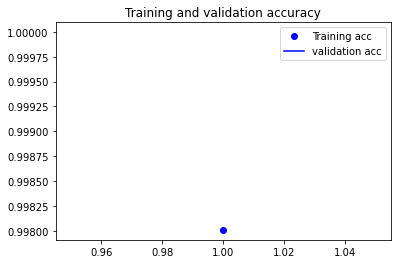

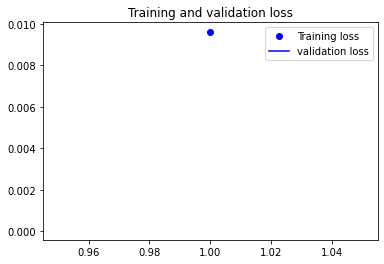

[6.14864329691045e-05]
1
6.14864329691045e-05 0
8820/8820 [==============================] - 2133s 242ms/step - loss: 0.0013 - accuracy: 0.9999 - val_loss: 9.7176e-11 - val_accuracy: 1.0000

CAN dataset using Keras/TensorFlow 
Loading CAN data into memory
<class 'dict'>
{'T0': 0, 'T1': 1}
(10742, 1)
(250869, 1)
(10742, 10, 16)
(1064427, 10, 16)
测试集上的loss和acc：
[1.715430335025303e-05, 0.9999980926513672]
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000    895105
           1     1.0000    1.0000    1.0000    169322

    accuracy                         1.0000   1064427
   macro avg     1.0000    1.0000    1.0000   1064427
weighted avg     1.0000    1.0000    1.0000   1064427

[[895105      0]
 [     2 169320]]


In [128]:
train_and_test('SpoofingGEAR3_train_final.csv','SpoofingGEAR3_test_final.csv','SpoofingGEAR3_final.h5')

In [129]:
from keras.models import load_model
one_model = load_model('Fuzzy_final.h5')
one_model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_45 (LSTM)               (None, 10, 256)           279552    
_________________________________________________________________
dropout_45 (Dropout)         (None, 10, 256)           0         
_________________________________________________________________
lstm_46 (LSTM)               (None, 10, 128)           197120    
_________________________________________________________________
dropout_46 (Dropout)         (None, 10, 128)           0         
_________________________________________________________________
lstm_47 (LSTM)               (None, 32)                20608     
_________________________________________________________________
dropout_47 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 32)              